### Model description and features
XGB model on all users that added product on July 2016,  

Features:
--------
*  xgb model trained on all months on added products and more features
   features generated from last 4 months
   product changes features like: product_exists_atleast_once, product_exists_in_all_months
   product_doesnt_exist_in_all_months, product_removed_in_the_past
   product_added_in_the_past

* features generated from the last four months product subscriptions
* and raw product subscriptions of the past 4 months


* load computed train and test sets from S3, and do a cross validation to find the best xgb params..


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


In [3]:
pickle_file = '/dev/xgb_train_test.train_data'

time: 933 µs


In [4]:
description, train, test, added_products, label_encoder = pickle.load(open(pickle_file, 'rb'))

time: 1min 15s


In [5]:
print train.shape
print added_products.shape
print test.shape

(441652, 283)
(441652, 2)
(929615, 285)
time: 1.59 ms


In [6]:
xgb_main = xgb.DMatrix(train, label=added_products.encoded_products)

time: 2.88 s


In [7]:
def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

time: 3.47 ms


In [10]:
# param = {}
# param['objective'] = 'multi:softprob'
# param['eta'] = 0.05
# param['max_depth'] = 6
# param['silent'] = 0
# param['num_class'] = len(label_encoder.classes_)
# param['eval_metric'] = "mlogloss"
# param['min_child_weight'] = 2
# param['subsample'] = 0.9
# param['colsample_bytree'] = 0.9

orig_params = {'colsample_bytree': 0.9,
                'eta': 0.1,
                'max_delta_step': 7,
                'max_depth': 6,
                'min_child_weight': 2,
                'objective': 'multi:softprob',
                'scale_pos_weight': 0,
                'subsample': 0.9,
                'silent': 1
            }

tup = lambda t: list(itertools.izip(itertools.repeat(t[0]), t[1]))

def get_list_of_params(params_range):
    pr = list(map(tup, params_range.items()))
    pro = map(dict, list(itertools.product(*pr)))
    return pro


def grid_search_xgb(params_range_dict):
    grid_params_list = get_list_of_params(params_range_dict)
    p = Pool(2)
    maps = map(get_map_of_xgb, grid_params_list)
    p.close()
    p.join()
    sorted_maps = sorted(maps, cmp = lambda x, y: cmp(x['map'], y['map']), reverse = True)
    print "top map results", sorted_maps[:3]
    return sorted_maps

def get_map_of_xgb(grid_param):
    cv_params = dict(orig_params)
    num_class = {'num_class': len(label_encoder.classes_)}
    cv_params.update(num_class)
    cv_params.update(grid_param)
    # print orig_params, grid_param
    temp_cv = xgb.cv(cv_params, xgb_main, num_boost_round = 5, stratified=True,
             early_stopping_rounds = 20, feval = map7eval, maximize = True)
    temp_map = temp_cv['test-MAP@7-mean'][temp_cv.shape[0]-1]
    grid_param['map'] = temp_map
    # print "cv results", grid_param
    return grid_param

param_range1 = {
    'max_depth': range(4, 8, 2),
    'min_child_weight': range(1, 4, 2)
}
param_range2 = {
    'gamma': [i for i in [0.1, 0.5] + range(0, 3)]
}

param_range21 = {
    'colsample_bylevel': [i/100.0 for i in range(80, 100, 5)]
}
param_range3 = {
    'max_delta_step': range(5, 9, 2) + [0]
}
# param_range4 = {
#     'subsample': [i/100.0 for i in range(80, 100, 5)],
#     'colsample_bytree': [i/100.0 for i in range(80, 100, 5)]
# }

param_range5 = {
    'scale_pos_weight': [i/10.0 for i in range(0, 7, 2)]
}

time: 40.2 ms


In [11]:
for param_range in [param_range1, param_range2, param_range21, param_range3, param_range5]:#, param_range2, param_range3, param_range4, param_range5]:
    result = None
    try:
        result = grid_search_xgb(param_range)
    except Exception, e:
        print e
        print traceback.format_exc()

    if result != None:
        temp_param = result[0]
        del(temp_param['map'])
        orig_params.update(temp_param)

top map results [{'map': 0.76541266666666663, 'max_depth': 6, 'min_child_weight': 1}, {'map': 0.76541033333333341, 'max_depth': 6, 'min_child_weight': 3}, {'map': 0.75257433333333335, 'max_depth': 4, 'min_child_weight': 3}]
top map results [{'map': 0.76542633333333343, 'gamma': 2}, {'map': 0.76541266666666663, 'gamma': 0}, {'map': 0.76541033333333341, 'gamma': 0.1}]
top map results [{'map': 0.76519966666666672, 'colsample_bylevel': 0.95}, {'map': 0.76495733333333327, 'colsample_bylevel': 0.85}, {'map': 0.76477666666666666, 'colsample_bylevel': 0.9}]
top map results [{'map': 0.76519966666666672, 'max_delta_step': 7}, {'map': 0.76503433333333337, 'max_delta_step': 0}, {'map': 0.76439833333333329, 'max_delta_step': 5}]
top map results [{'scale_pos_weight': 0.0, 'map': 0.76519966666666672}, {'scale_pos_weight': 0.2, 'map': 0.76519966666666672}, {'scale_pos_weight': 0.4, 'map': 0.76519966666666672}]
time: 2h 32min 58s


In [13]:
orig_params

{'colsample_bylevel': 0.95,
 'colsample_bytree': 0.9,
 'eta': 0.1,
 'gamma': 2,
 'max_delta_step': 7,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'multi:softprob',
 'scale_pos_weight': 0.0,
 'silent': 1,
 'subsample': 0.9}

time: 2.49 ms


In [12]:
gc.collect()

128

time: 32.9 ms


## End
---

In [14]:
# update params from orig params above and change eta and number of iterations

param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['max_delta_step'] = 7
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['colsample_bylevel'] = 0.95
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(xgb_main, 'train')]

time: 7.26 ms


In [15]:
xgb_model = xgb.train(plist, xgb_main, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.758738
[1]	train-MAP@7:0.761532
[2]	train-MAP@7:0.763382
[3]	train-MAP@7:0.763959
[4]	train-MAP@7:0.764163
[5]	train-MAP@7:0.764742
[6]	train-MAP@7:0.76488
[7]	train-MAP@7:0.765544
[8]	train-MAP@7:0.765691
[9]	train-MAP@7:0.767582
[10]	train-MAP@7:0.768055
[11]	train-MAP@7:0.768311
[12]	train-MAP@7:0.768619
[13]	train-MAP@7:0.768804
[14]	train-MAP@7:0.76909
[15]	train-MAP@7:0.769212
[16]	train-MAP@7:0.769624
[17]	train-MAP@7:0.769783
[18]	train-MAP@7:0.769977
[19]	train-MAP@7:0.770054
[20]	train-MAP@7:0.770158
[21]	train-MAP@7:0.770351
[22]	train-MAP@7:0.770464
[23]	train-MAP@7:0.770679
[24]	train-MAP@7:0.770835
[25]	train-MAP@7:0.770978
[26]	train-MAP@7:0.771116
[27]	train-MAP@7:0.77132
[28]	train-MAP@7:0.771467
[29]	train-MAP@7:0.771623
[30]	train-MAP@7:0.771836
[31]	train-MAP@7:0.771891
[32]	train-MAP@7:0.771999
[33]	train-MAP@7:0.77209
[34]	train-MAP@7:0.772241
[35]	train-MAP@7:0.772339
[36]	train-MAP@7:0.772461
[37]	train-MAP@7:0.772549
[38]	train-MAP@7:0.77271
[

In [18]:
del test['xgb_preds'], test['added_products']

time: 296 ms


In [20]:
final_test = xgb.DMatrix(test)
preds = xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]

HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [13:18<00:00, 1163.79it/s]

time: 13min 18s


In [21]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/12.xgb_trained_on_all_months_only_added_product_features_generated_from_last_4_months_with_cv.csv'
description = '12. xgb model 200 iter with cross validation done\
               trained on all months on added products and more features\
               features generated from last 4 months\
               product changes features like: product_exists_atleast_once, product_exists_in_all_months,\
               product_doesnt_exist_in_all_months, product_removed_in_the_past,\
               product_added_in_the_past, product_removed_recently, product_added_recently, and\
               the actual product submission information\n' + str(param)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/12.xgb_trained_on_all_months_only_added_product_features_generated_from_last_4_months_with_cv.csv.zip
uploading to s3 done
Uploading submission data/12.xgb_trained_on_all_months_only_added_product_features_generated_from_last_4_months_with_cv.csv.zip
Upload done
time: 1min 4s


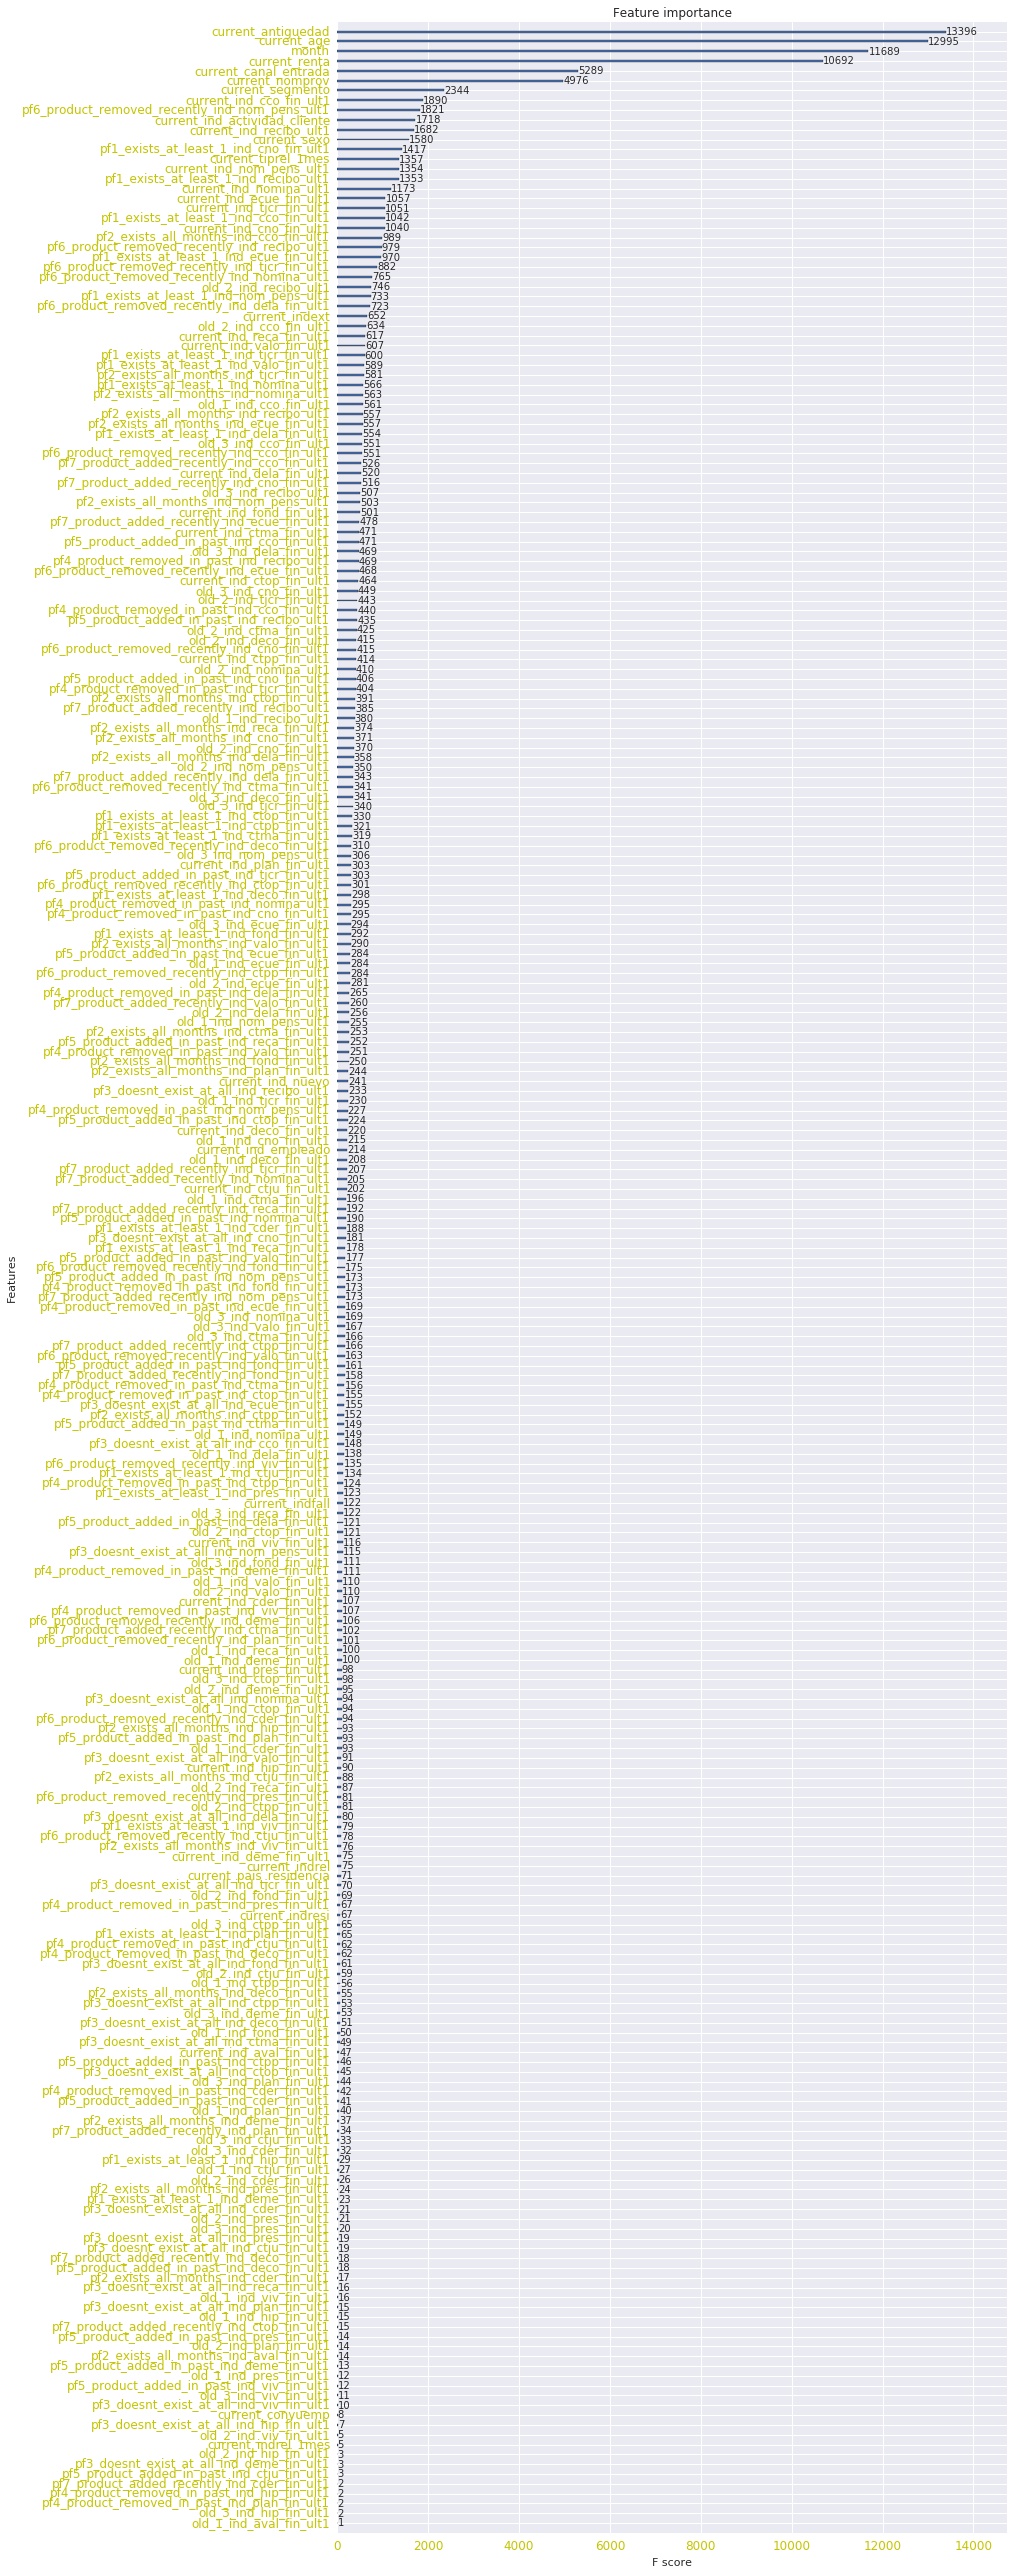

time: 5.19 s


In [22]:
pylab.rcParams['figure.figsize'] = (12, 45)
xgb.plot_importance(xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c4c400")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

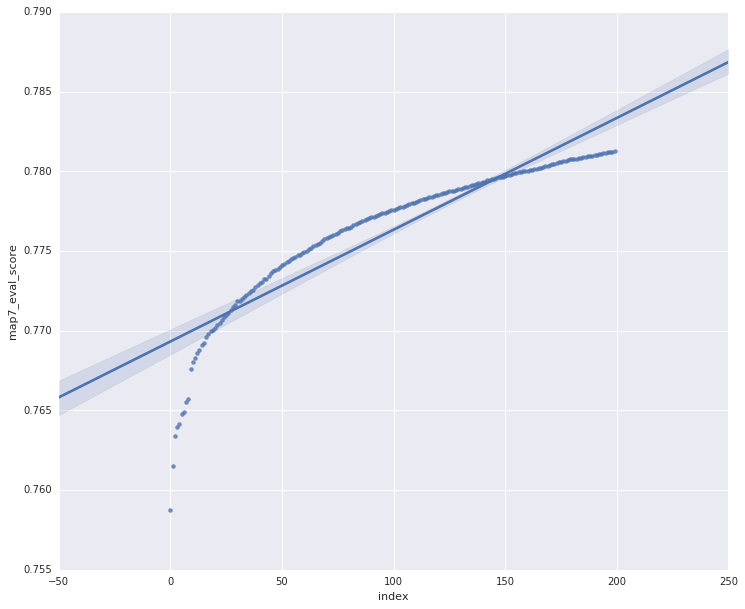

time: 833 ms


In [23]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_eval_score'] = evals_result['train']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
sns.regplot(x='index', y='map7_eval_score', data = p2)

In [24]:
pickle_description = '12. Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/12.xgb_trained_on_all_months_only_added_product_features_generated_from_last_4_months_with_cv.csv.pickle.zip
uploading to s3 done
time: 1min 18s
